In [11]:
import json
import matplotlib
import matplotlib.pyplot as plt
import glob
import os
import numpy as np
from cycler import cycler
cm = plt.cm.tab10.colors
cycle = (cycler(color=cm) * cycler(linestyle=['-', '--', '-.']))
# for d in cycle:
#     print(d)
plt.rcParams['figure.figsize'] = [16, 16]
matplotlib.rcParams['figure.dpi'] = 300

In [94]:
from scipy.stats import mannwhitneyu

In [304]:
# See https://matplotlib.org/2.0.0/examples/color/named_colors.html
# And https://matplotlib.org/2.1.1/api/_as_gen/matplotlib.pyplot.plot.html
colorDict = {
    "GOM_LearnedLT": ("tomato", "-"),
    "GOM_UniOrd": ("steelblue", "--"),
    "GOM_UniOrdReversed" : ("steelblue", "-"),
    "GOM_UniUnord": ("steelblue", "-."),
    "GOM_incrLT": ("green", "-"),
    "GOM_incrLT-UniOrd": ("g", "--"),
    "GOM_incrLTReversed": ("mediumorchid", "-"),
    "GOM_incrLTReversed-Uni": ("mediumorchid", "--"),
    "GOM_incrLTReversed-UniOrd": ("mediumorchid", "-."),
    "RandomSearch": ("darkorange", "-"),
    "SimpleGA_s=tour2_v=op": ("y", "-"),
    "SimpleGA_s=tour2_v=uni": ("y", "--"),
    "LocalSearch-rand": ("darkturquoise", "-")
}

In [127]:
from jsonmerge import merge
import json

def mergeJSON(folder, json_1_file_loc, json_2_file_loc, result_file_loc):
    with open(folder + json_1_file_loc) as json_file:
        json1 = json.load(json_file)
#         for p in json1['sel=tour2']:
#             print(p)

    with open(folder + json_2_file_loc) as json_file:
        json2 = json.load(json_file)
#         for p in json2['sel=tour2']:
#             print(p)
            
    result = merge(json1, json2)

    with open(folder + result_file_loc, 'w') as outfile:
        json.dump(result, outfile)

def combineMultiple(prepend, append, begin, end, outappend):
#     jsonBase
    filename = prepend + str(begin) + append
    with open(filename) as json_file:
        print ("base json", filename)
        jsonBase = json.load(json_file)
    
    for i in range(begin+1,end+1):
        filename = prepend + str(i) + append
        print ("adding", filename, "to the json")
        with open(filename) as json_file:
            jsonAdd = json.load(json_file)
            jsonBase = merge(jsonBase, jsonAdd)
    
    with open(prepend + outappend, 'w') as outfile:
        json.dump(jsonBase, outfile)

In [301]:
level = "12"

mergeJSON('../data/exp8/data_scaling_012/',
          'data_scaling_' + level + '.json',
          'data_scaling_' + level + '_lsrand.json', 
          'data_scaling_' + level + '.json')

In [302]:
combineMultiple("../data/exp8/data_scaling_012/data_scaling_", ".json", 2, 13, "_combined.json")



base json ../data/exp8/data_scaling_012/data_scaling_2.json
adding ../data/exp8/data_scaling_012/data_scaling_3.json to the json
adding ../data/exp8/data_scaling_012/data_scaling_4.json to the json
adding ../data/exp8/data_scaling_012/data_scaling_5.json to the json
adding ../data/exp8/data_scaling_012/data_scaling_6.json to the json
adding ../data/exp8/data_scaling_012/data_scaling_7.json to the json
adding ../data/exp8/data_scaling_012/data_scaling_8.json to the json
adding ../data/exp8/data_scaling_012/data_scaling_9.json to the json
adding ../data/exp8/data_scaling_012/data_scaling_10.json to the json
adding ../data/exp8/data_scaling_012/data_scaling_11.json to the json
adding ../data/exp8/data_scaling_012/data_scaling_12.json to the json
adding ../data/exp8/data_scaling_012/data_scaling_13.json to the json


# Experiment 6.1: All algorithms on ARK-1 (Convergence plots)

averages of 100 repetitions
averages of 100 repetitions


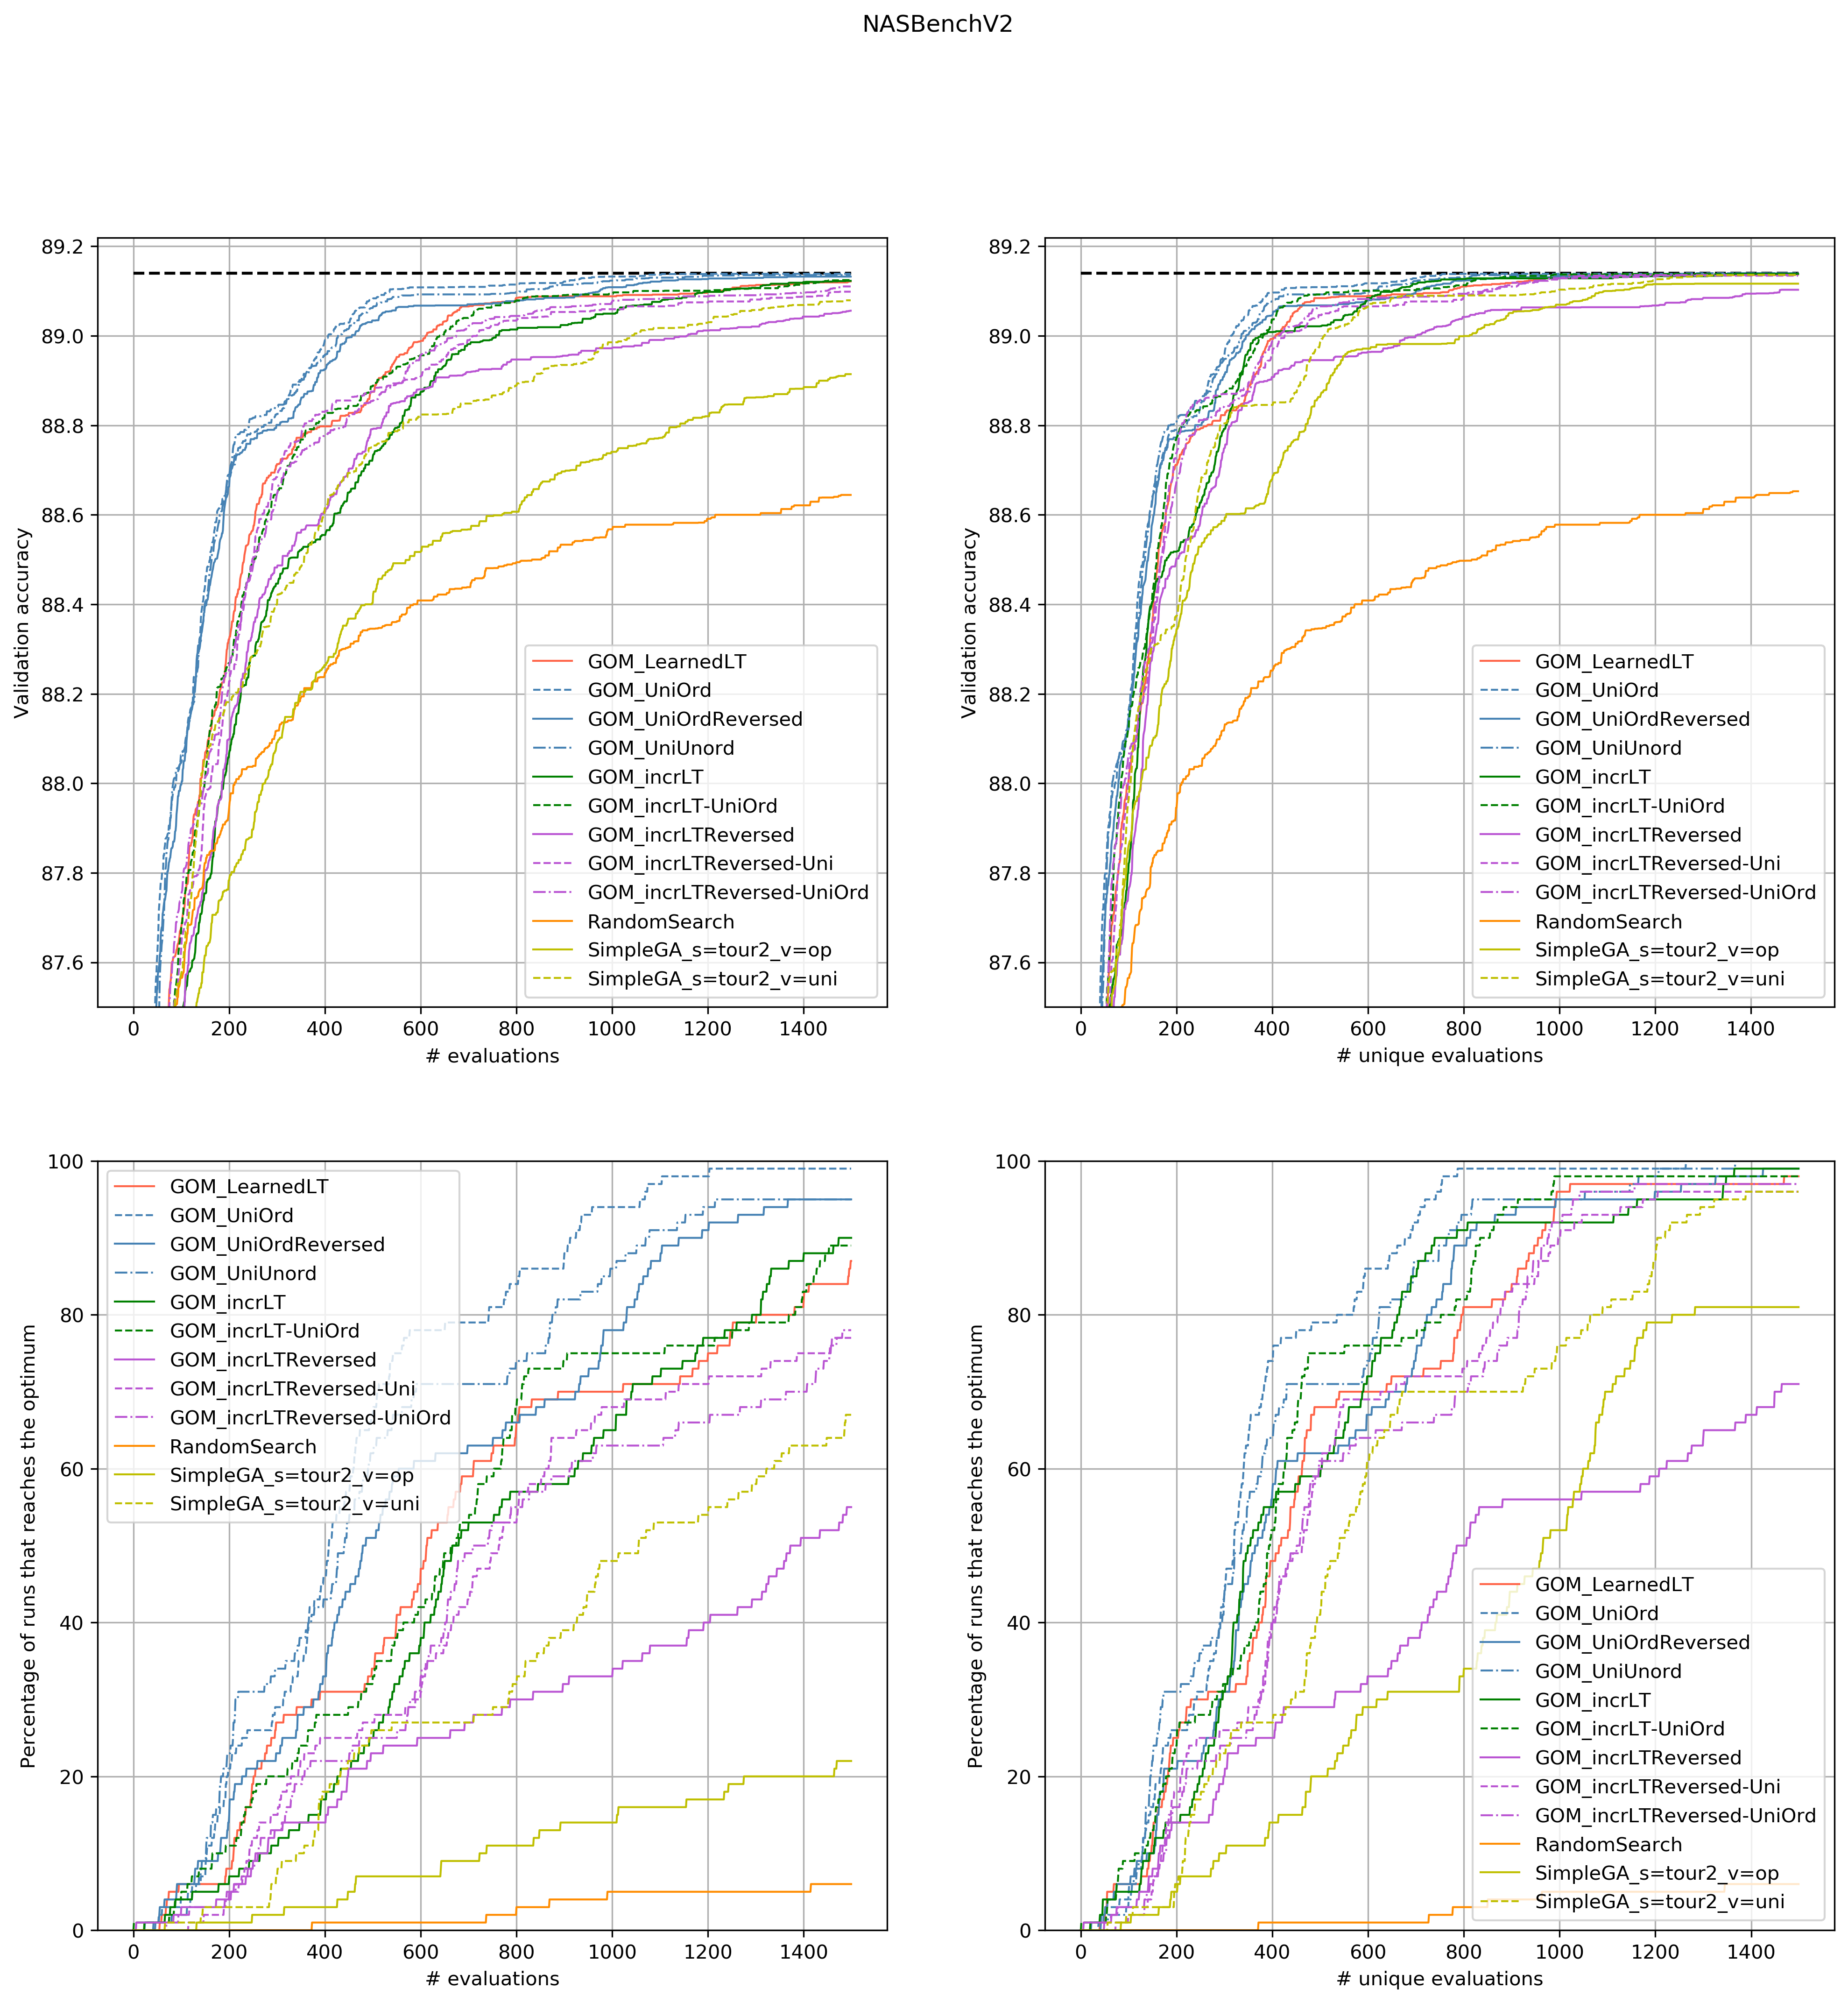

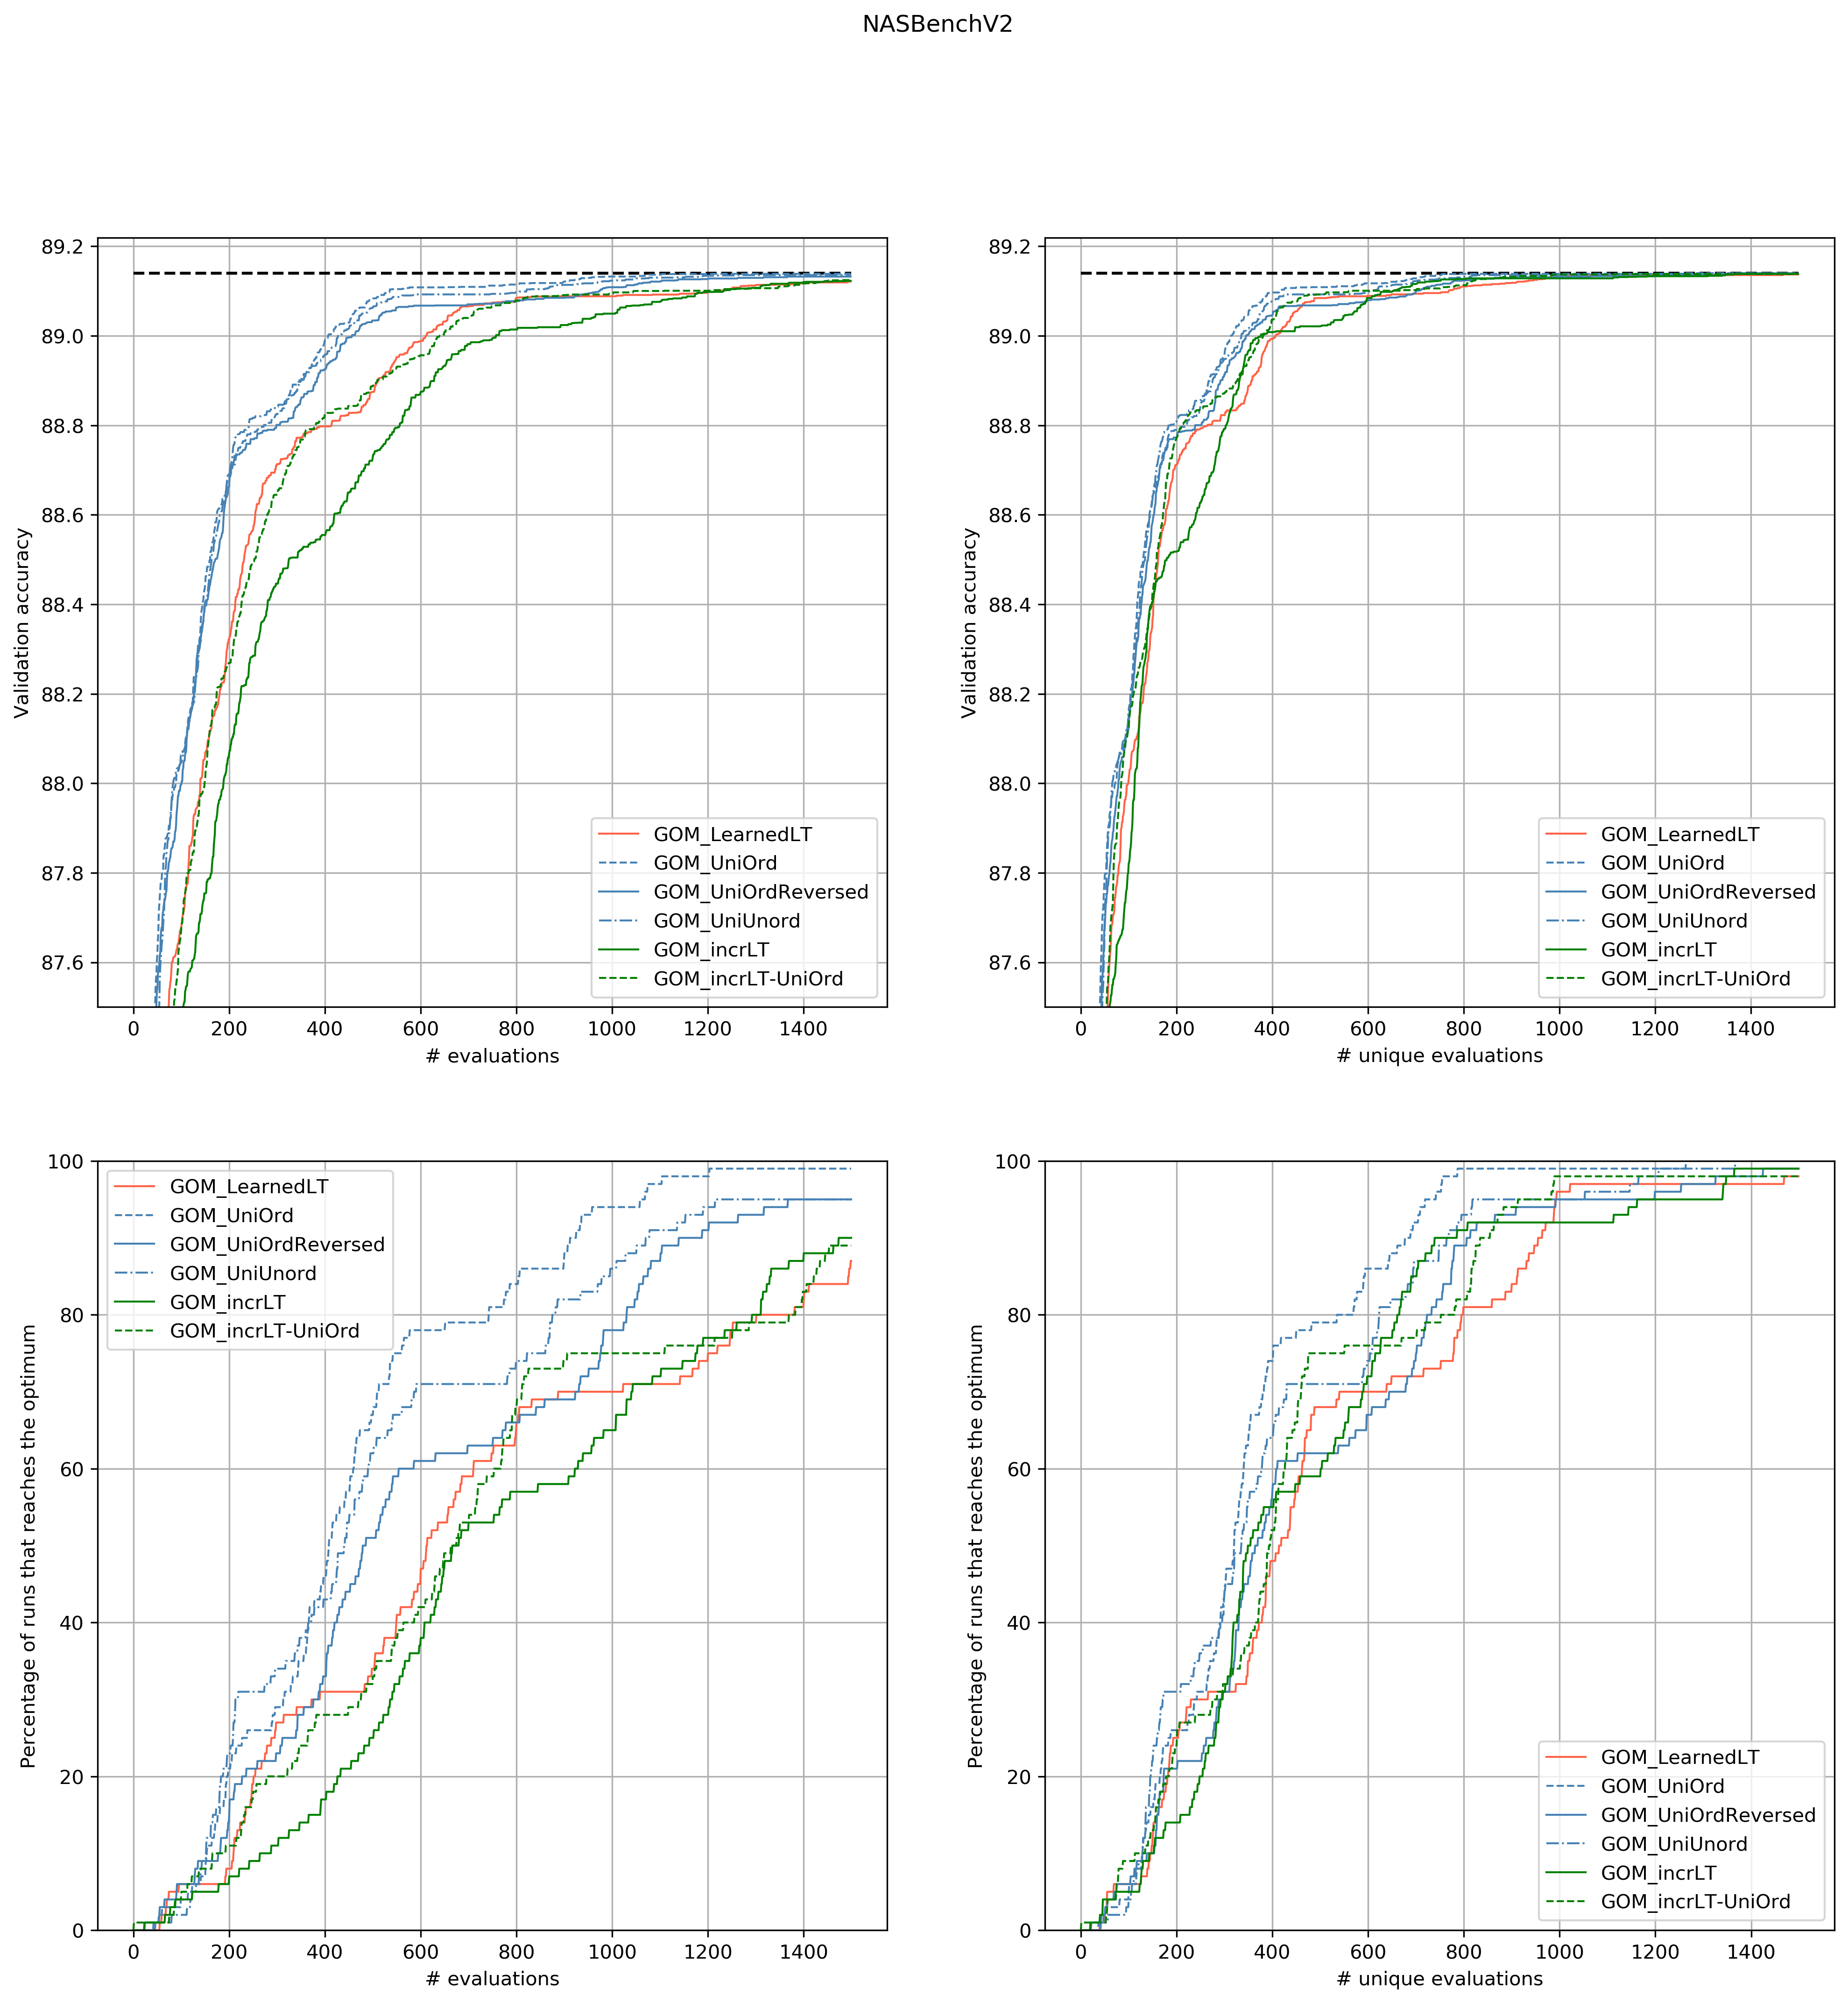

In [32]:
# Until 10000 absolute evaluations. Unique evaluations are also stored.
# Alphabet={0,1,2,3} (inlcuding identity layer).
filename = "../data/exp6/data_convergence_0123.json"

# Alphabet={0,1,2} (excluding identity layer).
# filename = "../data/exp6/data_convergence_012.json"

important = ["GOM_UniOrd", "GOM_UniOrdReversed", "GOM_UniUnord", 
             "GOM_LearnedLT", "GOM_incrLT", "GOM_incrLT-UniOrd"]

for importantOnly in [False, True]:
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
    firstplots = [ax1, ax2]
    secondplots = [ax3, ax4]
    cm = plt.cm.Set1.colors
    cycle = (cycler(color=cm) * cycler(linestyle=['-', '--']))
    for ax in [ax1,ax2,ax3,ax4]:
        ax.set_prop_cycle(cycle)

    numEvaluations = 1500;
    optimum = 89.13

    with open(filename) as json_file:
        rawdata = json.load(json_file)
        repetitions = rawdata["repetitions"]
        print("averages of", repetitions, "repetitions")

        fig.suptitle(rawdata['fitnessFunction'])
        algorithms = rawdata['experiments']
        totalBest = 0;

        for k, evaluationstype in enumerate(["absolute", "unique"]):

            for algo in algorithms:
                if(importantOnly and algo not in important):
                    continue
                data = algorithms[algo]["7"]
                numEntries = len(data)

                accuracies = np.zeros((numEntries, numEvaluations))
                optfound = np.zeros((numEntries, numEvaluations))

                for i, rep in enumerate(data):

                    convergenceValues = data[rep]["convergence"][evaluationstype]
                    fillUntil = min(len(convergenceValues), numEvaluations)

                    accuracies[i, 0:fillUntil] = convergenceValues[0:fillUntil]
                    if(fillUntil < numEvaluations):
                        accuracies[i, fillUntil:numEvaluations] = accuracies[i, fillUntil-1]

                    for j, value in enumerate(accuracies[i,:]):
                        if (value >= optimum):
                            optfound[i][j] = 1

                avgAccuracies = np.mean(accuracies, 0)
                stdAccuracies = np.std(accuracies, 0)

                totalOptfound = np.sum(optfound, 0) / repetitions * 100
                totalBest = max(totalBest, max(avgAccuracies))

                firstplots[k].plot(range(numEvaluations), avgAccuracies, label=algo, color=colorDict[algo][0], linestyle=colorDict[algo][1], linewidth=1)
#                 firstplots[k].fill_between(range(numEvaluations), avgAccuracies-stdAccuracies, avgAccuracies+stdAccuracies, alpha=0.1)

                secondplots[k].plot(range(numEvaluations), totalOptfound, label=algo, color=colorDict[algo][0], linestyle=colorDict[algo][1], linewidth=1)

            ax = firstplots[k]
            ax.set_ylim(87.5, optimum * 1.001)
            ax.legend()
            ax.set_xlabel('# evaluations')
            ax.set_ylabel('Validation accuracy')
            ax.hlines(89.14, 0, numEvaluations, linestyles='dashed')
        #     ax.set_xscale('log')
        #     ax.set_yscale('log')
            ax.grid()

            ax = secondplots[k]
            ax.set_ylim(0,100)
            ax.legend()
            ax.set_xlabel('# evaluations')
            ax.set_ylabel('Percentage of runs that reaches the optimum')
            ax.grid()

    ax2.set_xlabel("# unique evaluations")
    ax4.set_xlabel("# unique evaluations")


# Experiment 6.2: All algorithms on ARK-1 (Scalability Plots)

averages of 100 repetitions
averages of 100 repetitions


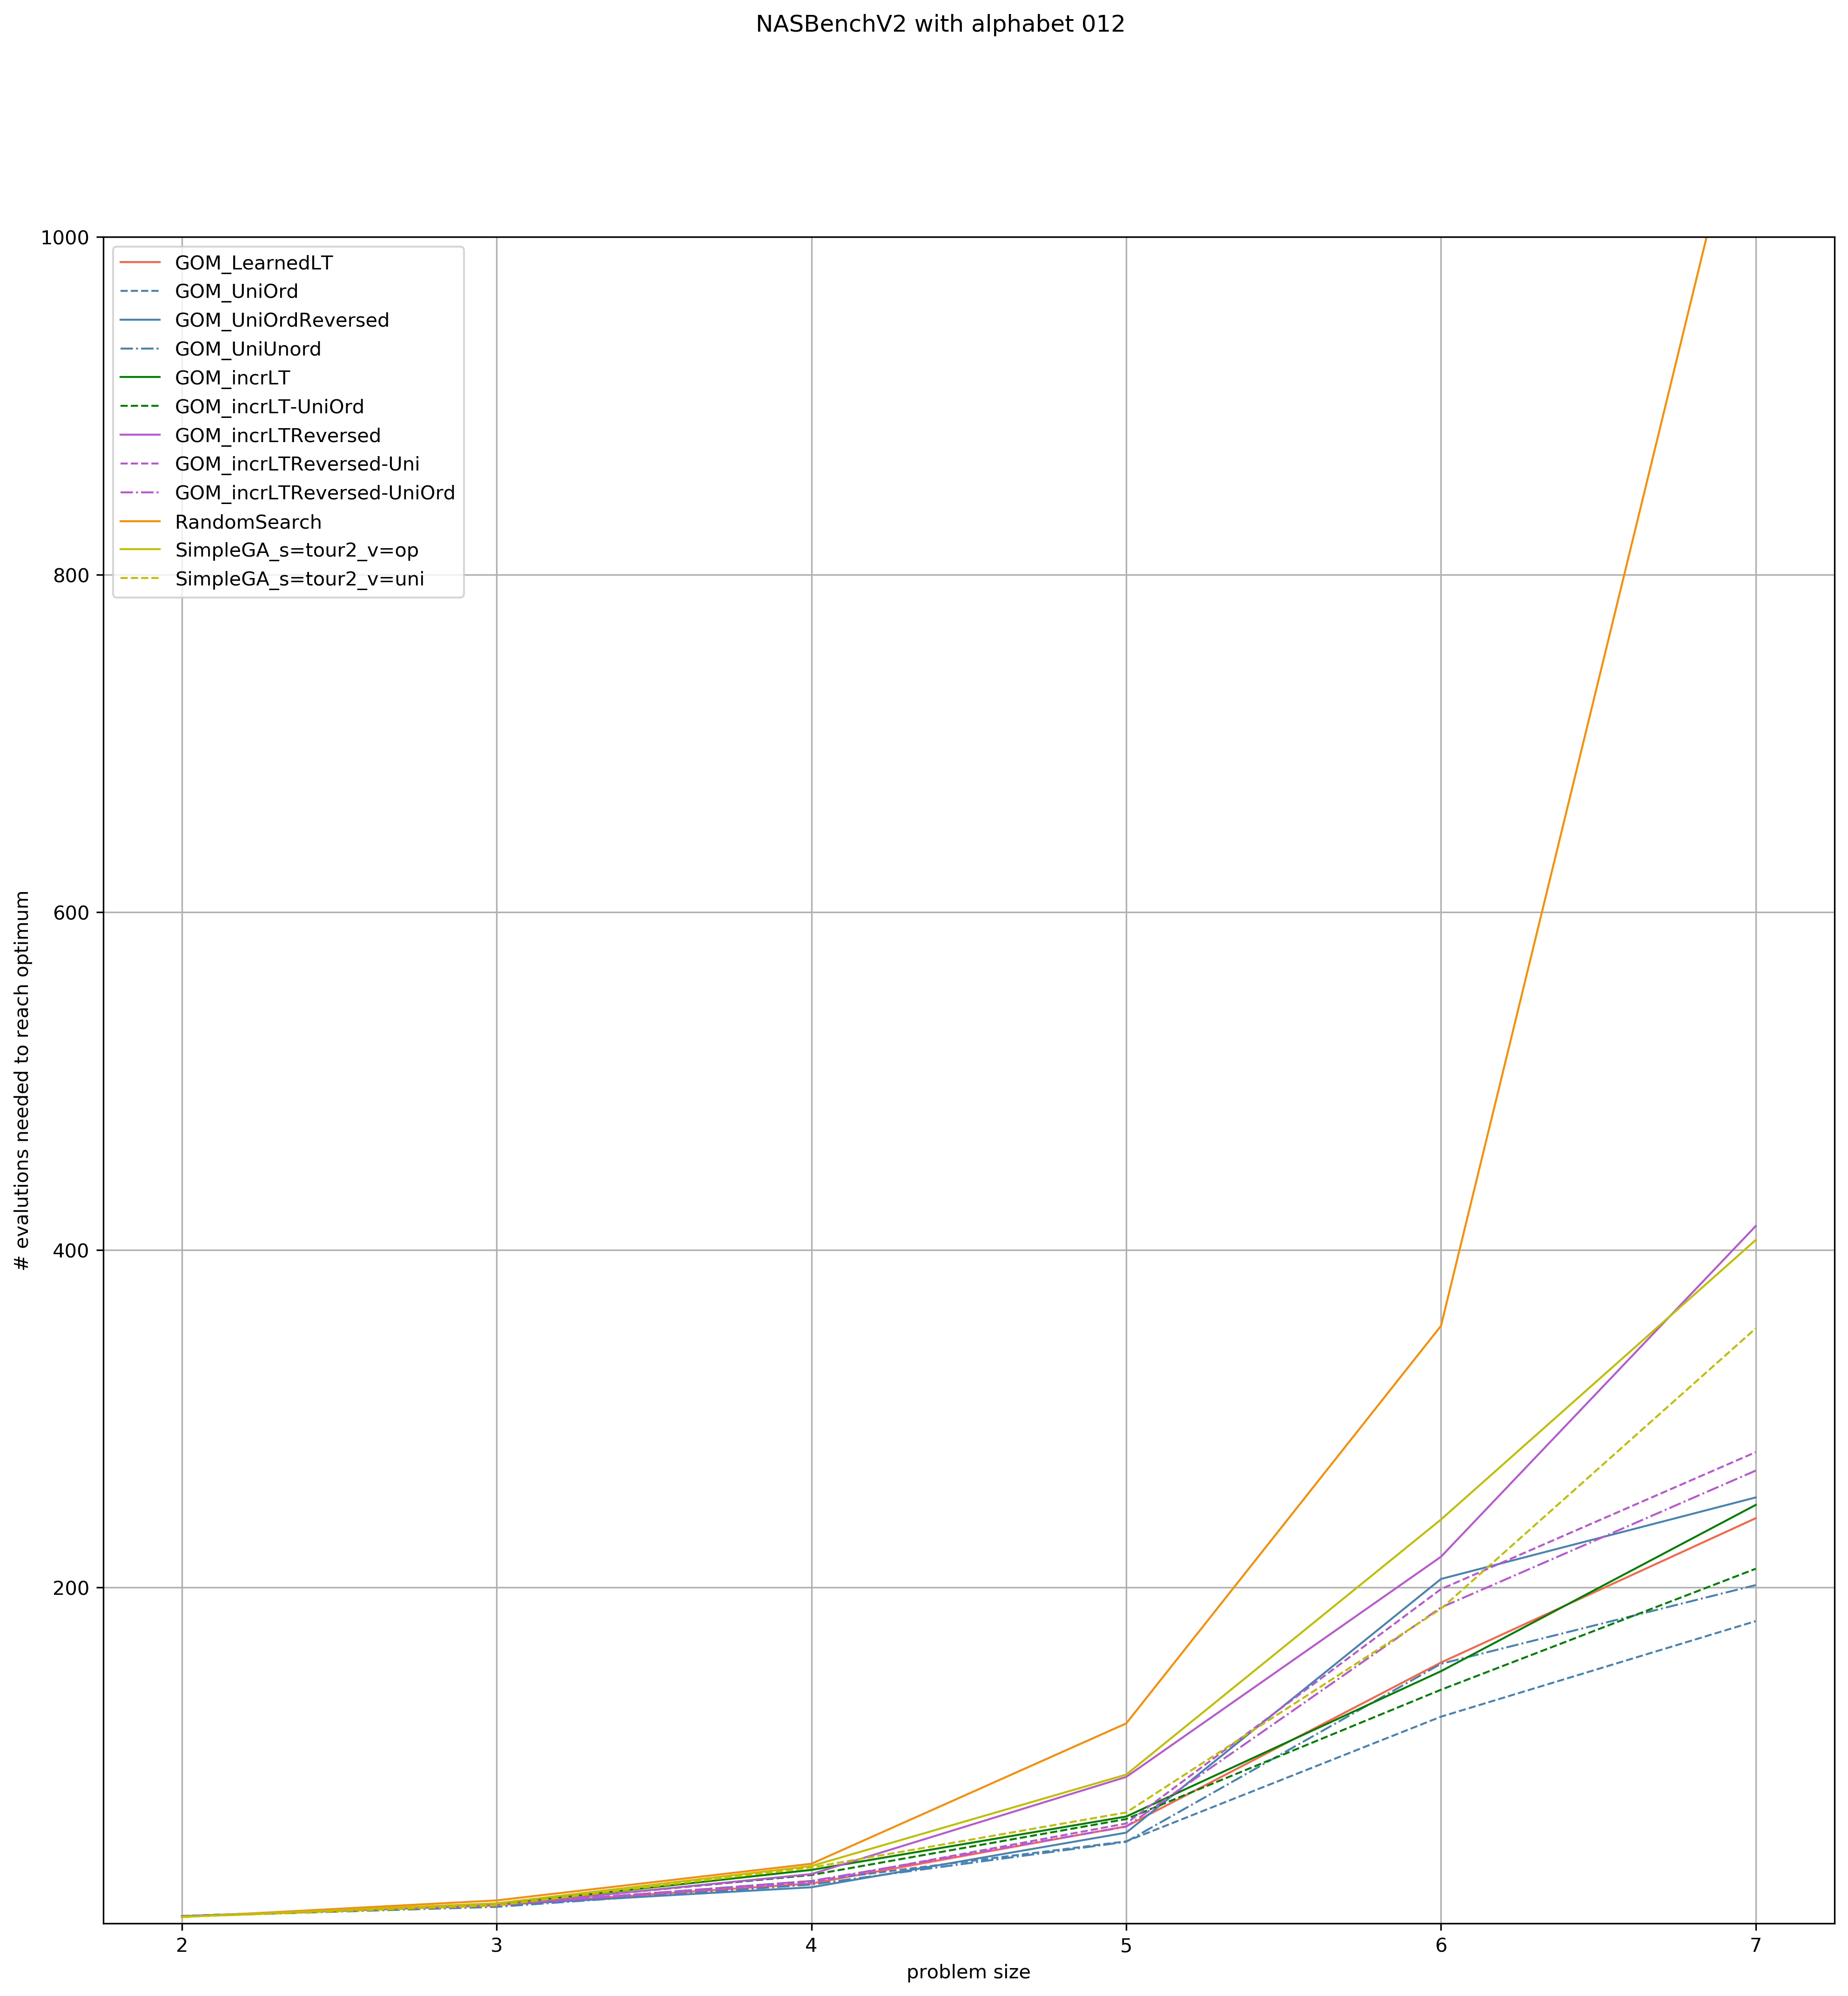

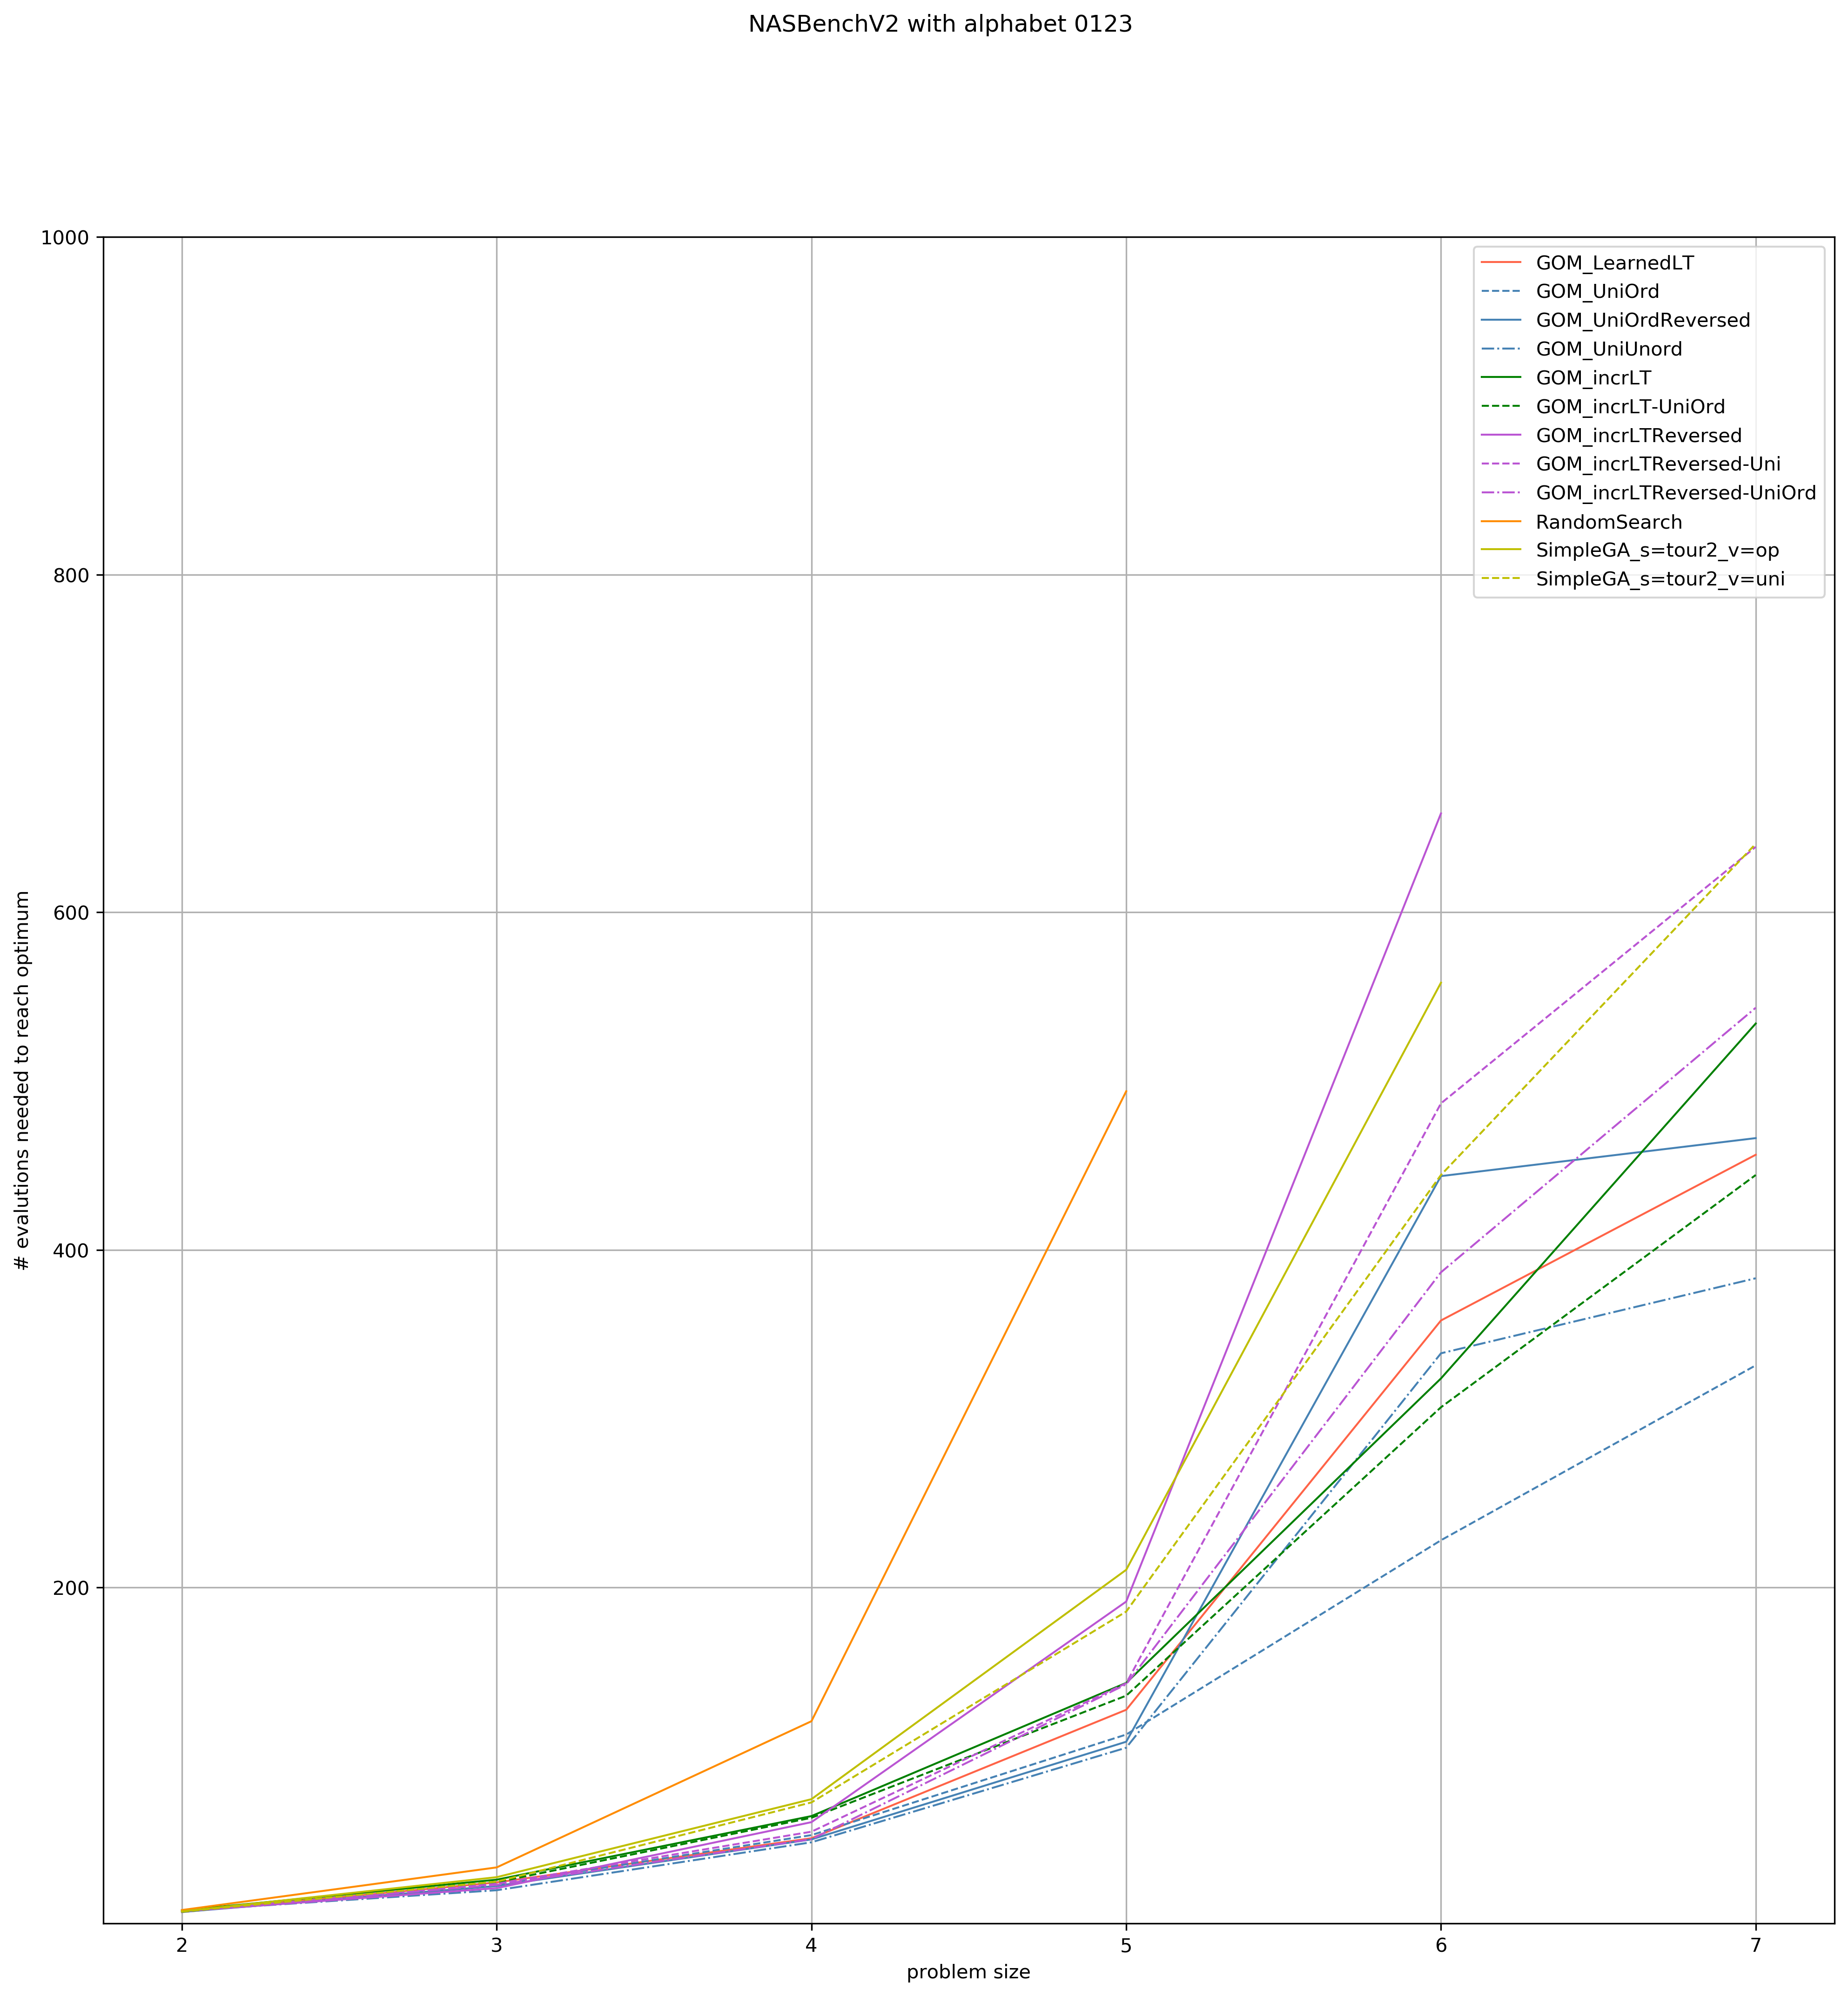

In [48]:
alphabet1 = "012"
alphabet2 = "0123"

for alphabet in [alphabet1, alphabet2]:
    fig, (ax1) = plt.subplots(1, 1)
    cm = plt.cm.Set1.colors
    cycle = (cycler(color=cm) * cycler(linestyle=['-', '--']))
    ax1.set_prop_cycle(cycle)
    ax2.set_prop_cycle(cycle)

    selection = ["GOM_LearnedLT", "GOM_UniOrd", "GOM_UniUnord", "GOM_UniOrdReversed"]

    filename = "../data/exp6/data_scaling_" + alphabet + "/data_combined.json"
    
    with open(filename) as json_file:
        rawdata = json.load(json_file)

        fig.suptitle(rawdata['fitnessFunction'] + " with alphabet " + alphabet)
        algorithms = rawdata['experiments']

        repetitions = rawdata['repetitions']

        numAlgos = len(algorithms)

    #     for algo in selection:
        for algo in algorithms:

            data = algorithms[algo]
            numEntries = len(data)

            Evaluations = np.zeros((numEntries, repetitions))
            Times = np.zeros((numEntries, repetitions))

            for i, problemsize in enumerate(data):

                for j, rep in enumerate(data[problemsize]):

                    Evaluations[i][j] = data[problemsize][rep]["uniqueEvaluations"]
                    Times[i][j] = data[problemsize][rep]["timeTaken"]

            avgEvaluations = np.mean(Evaluations, 1);
            stdEvaluations = np.std(Evaluations, 1);
            avgTimes = np.mean(Times, 1);
            stdTimes = np.std(Times, 1)

            xrange = range(2,numEntries+2)

            ax1.plot(xrange, avgEvaluations, label=algo, color=colorDict[algo][0], linestyle=colorDict[algo][1], linewidth=1)
    #         ax1.fill_between(xrange, avgEvaluations-stdEvaluations, avgEvaluations+stdEvaluations, alpha=0.1)
    #         ax1.errorbar(xrange, avgEvaluations, yerr=stdEvaluations)

    #         ax2.plot(xrange, avgTimes, label=algo)
    #         ax2.fill_between(xrange, avgTimes-stdTimes, avgTimes+stdTimes, alpha=0.1)

        ax1.set_ylim(1,1000)
        ax1.legend()
        ax1.set_xlabel('problem size')
        ax1.set_ylabel('# evalutions needed to reach optimum')
        ax1.grid()
#         ax1.set_yscale('log')
        
    
        print("averages of", repetitions, "repetitions")

# Experiment 8.1: All algorithms on ARK-2 (Convergence plots)

averages of 100 repetitions
averages of 100 repetitions


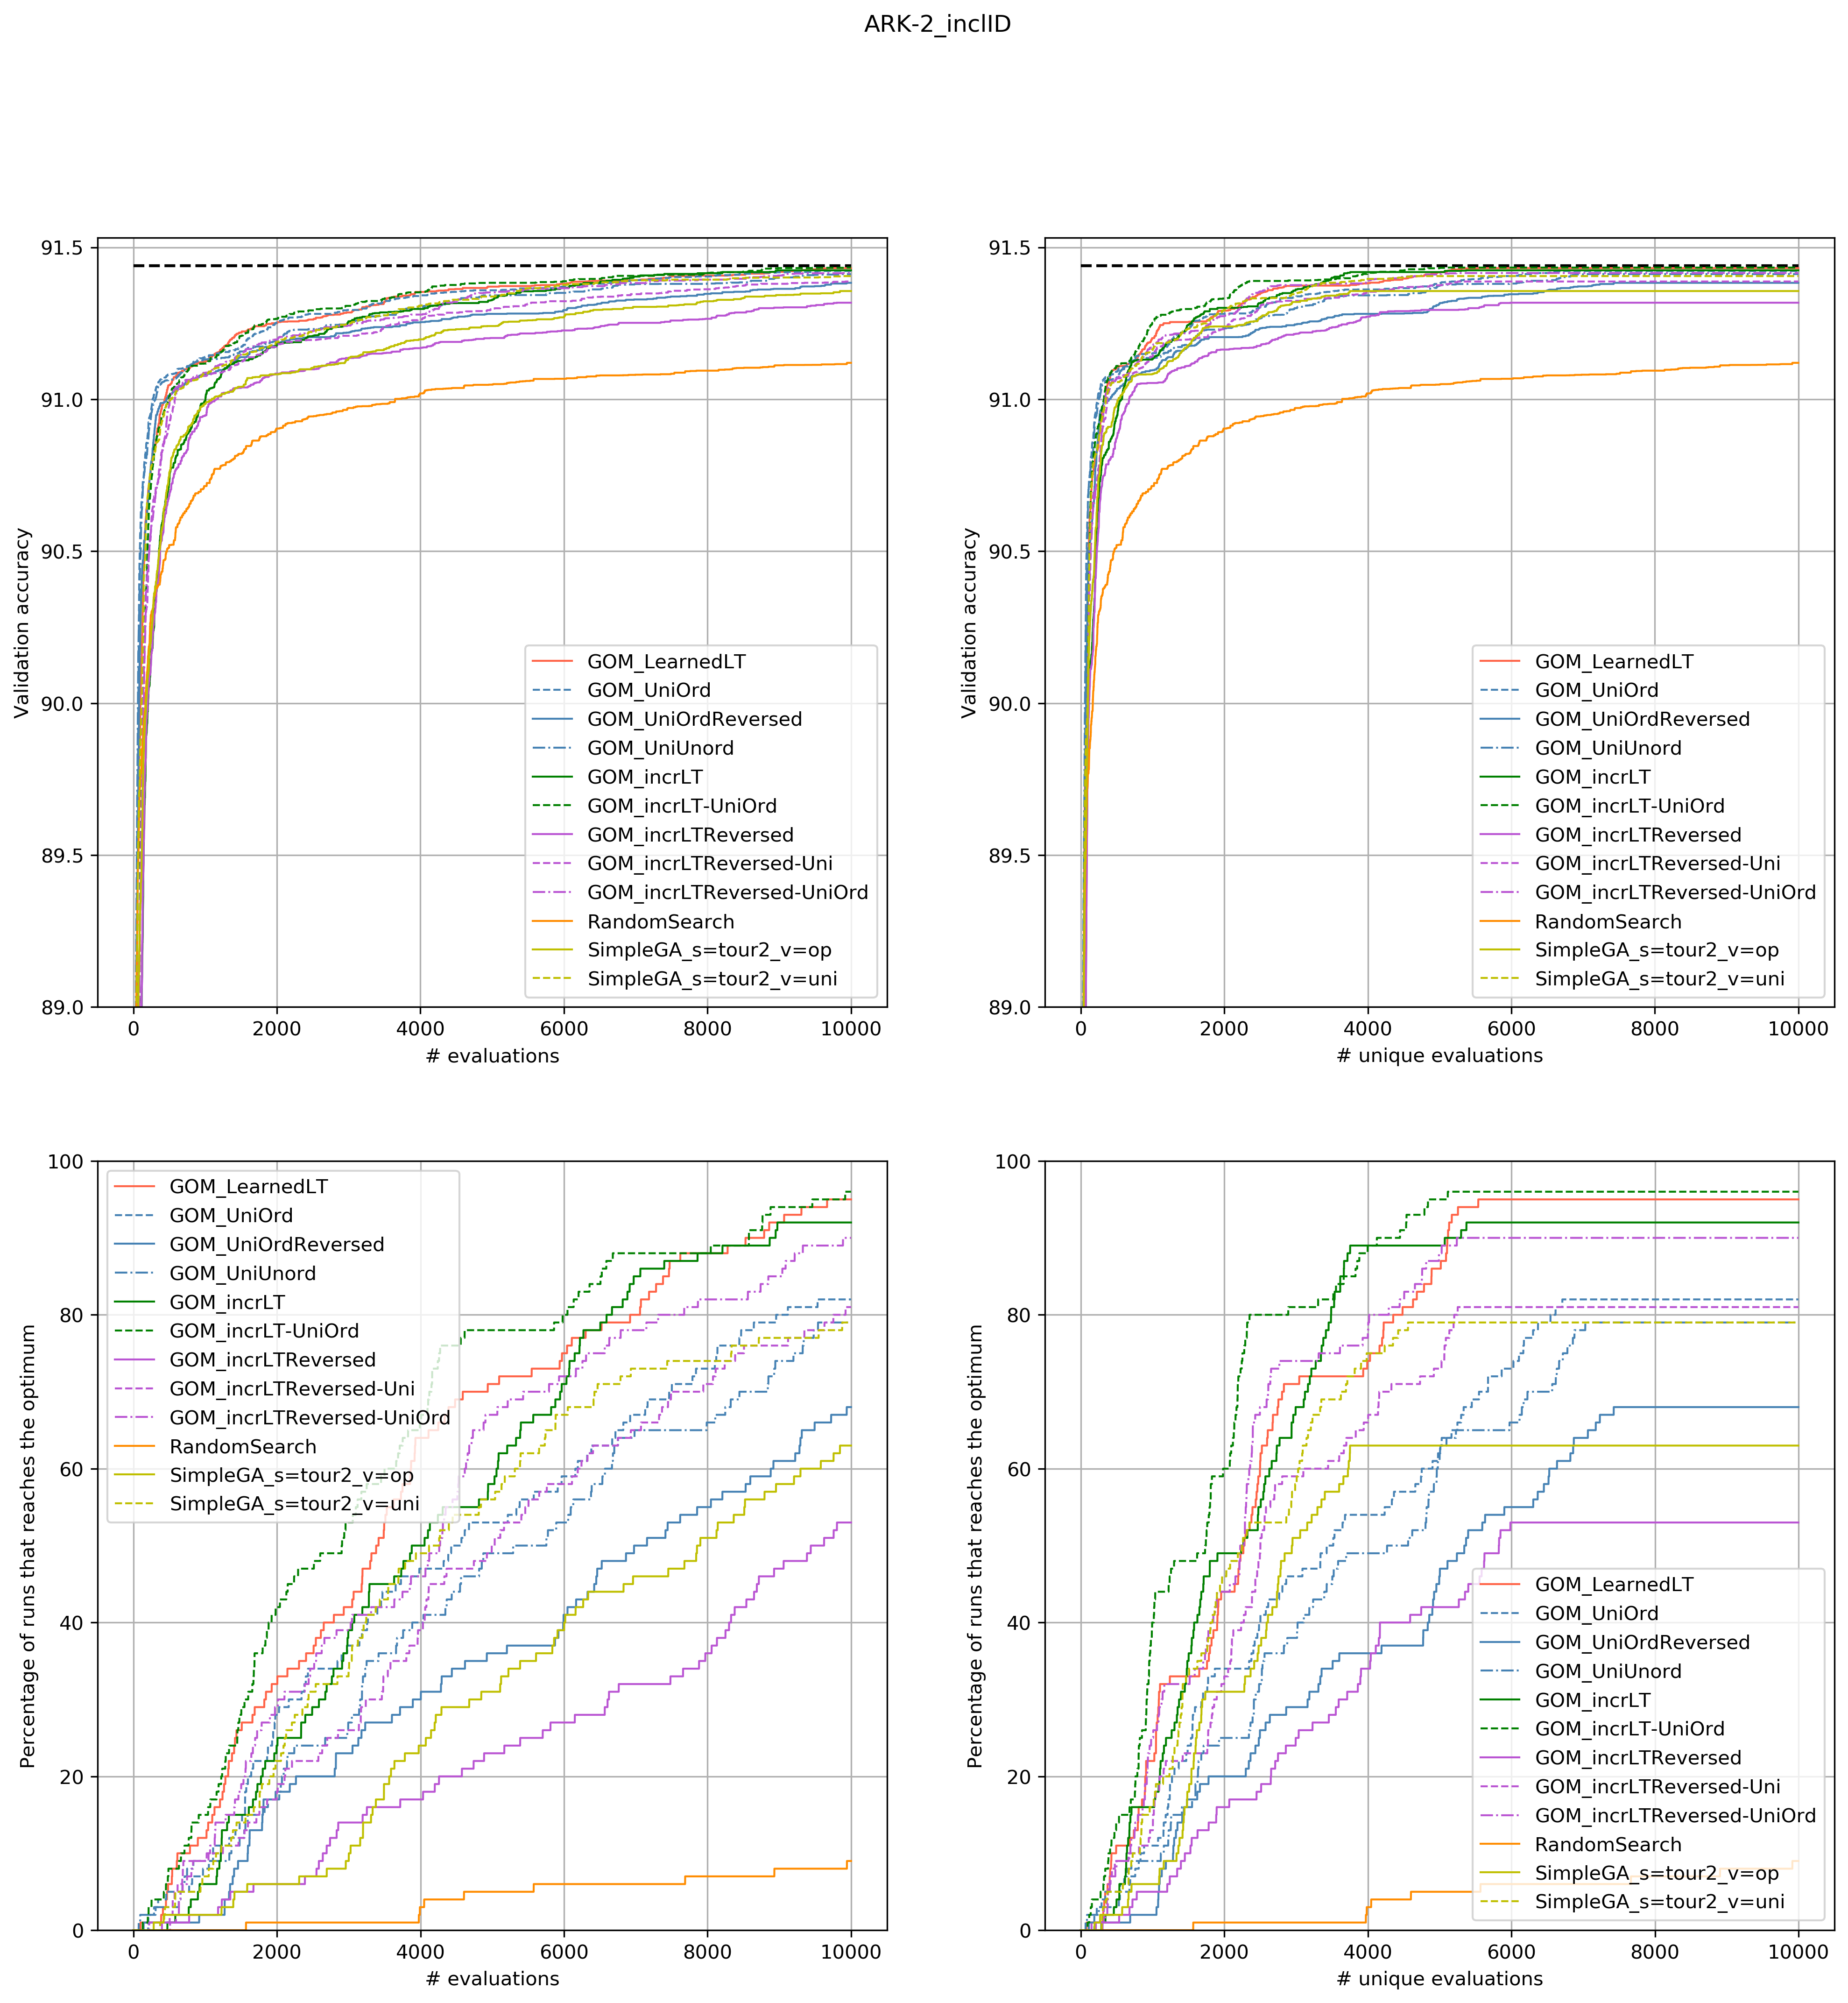

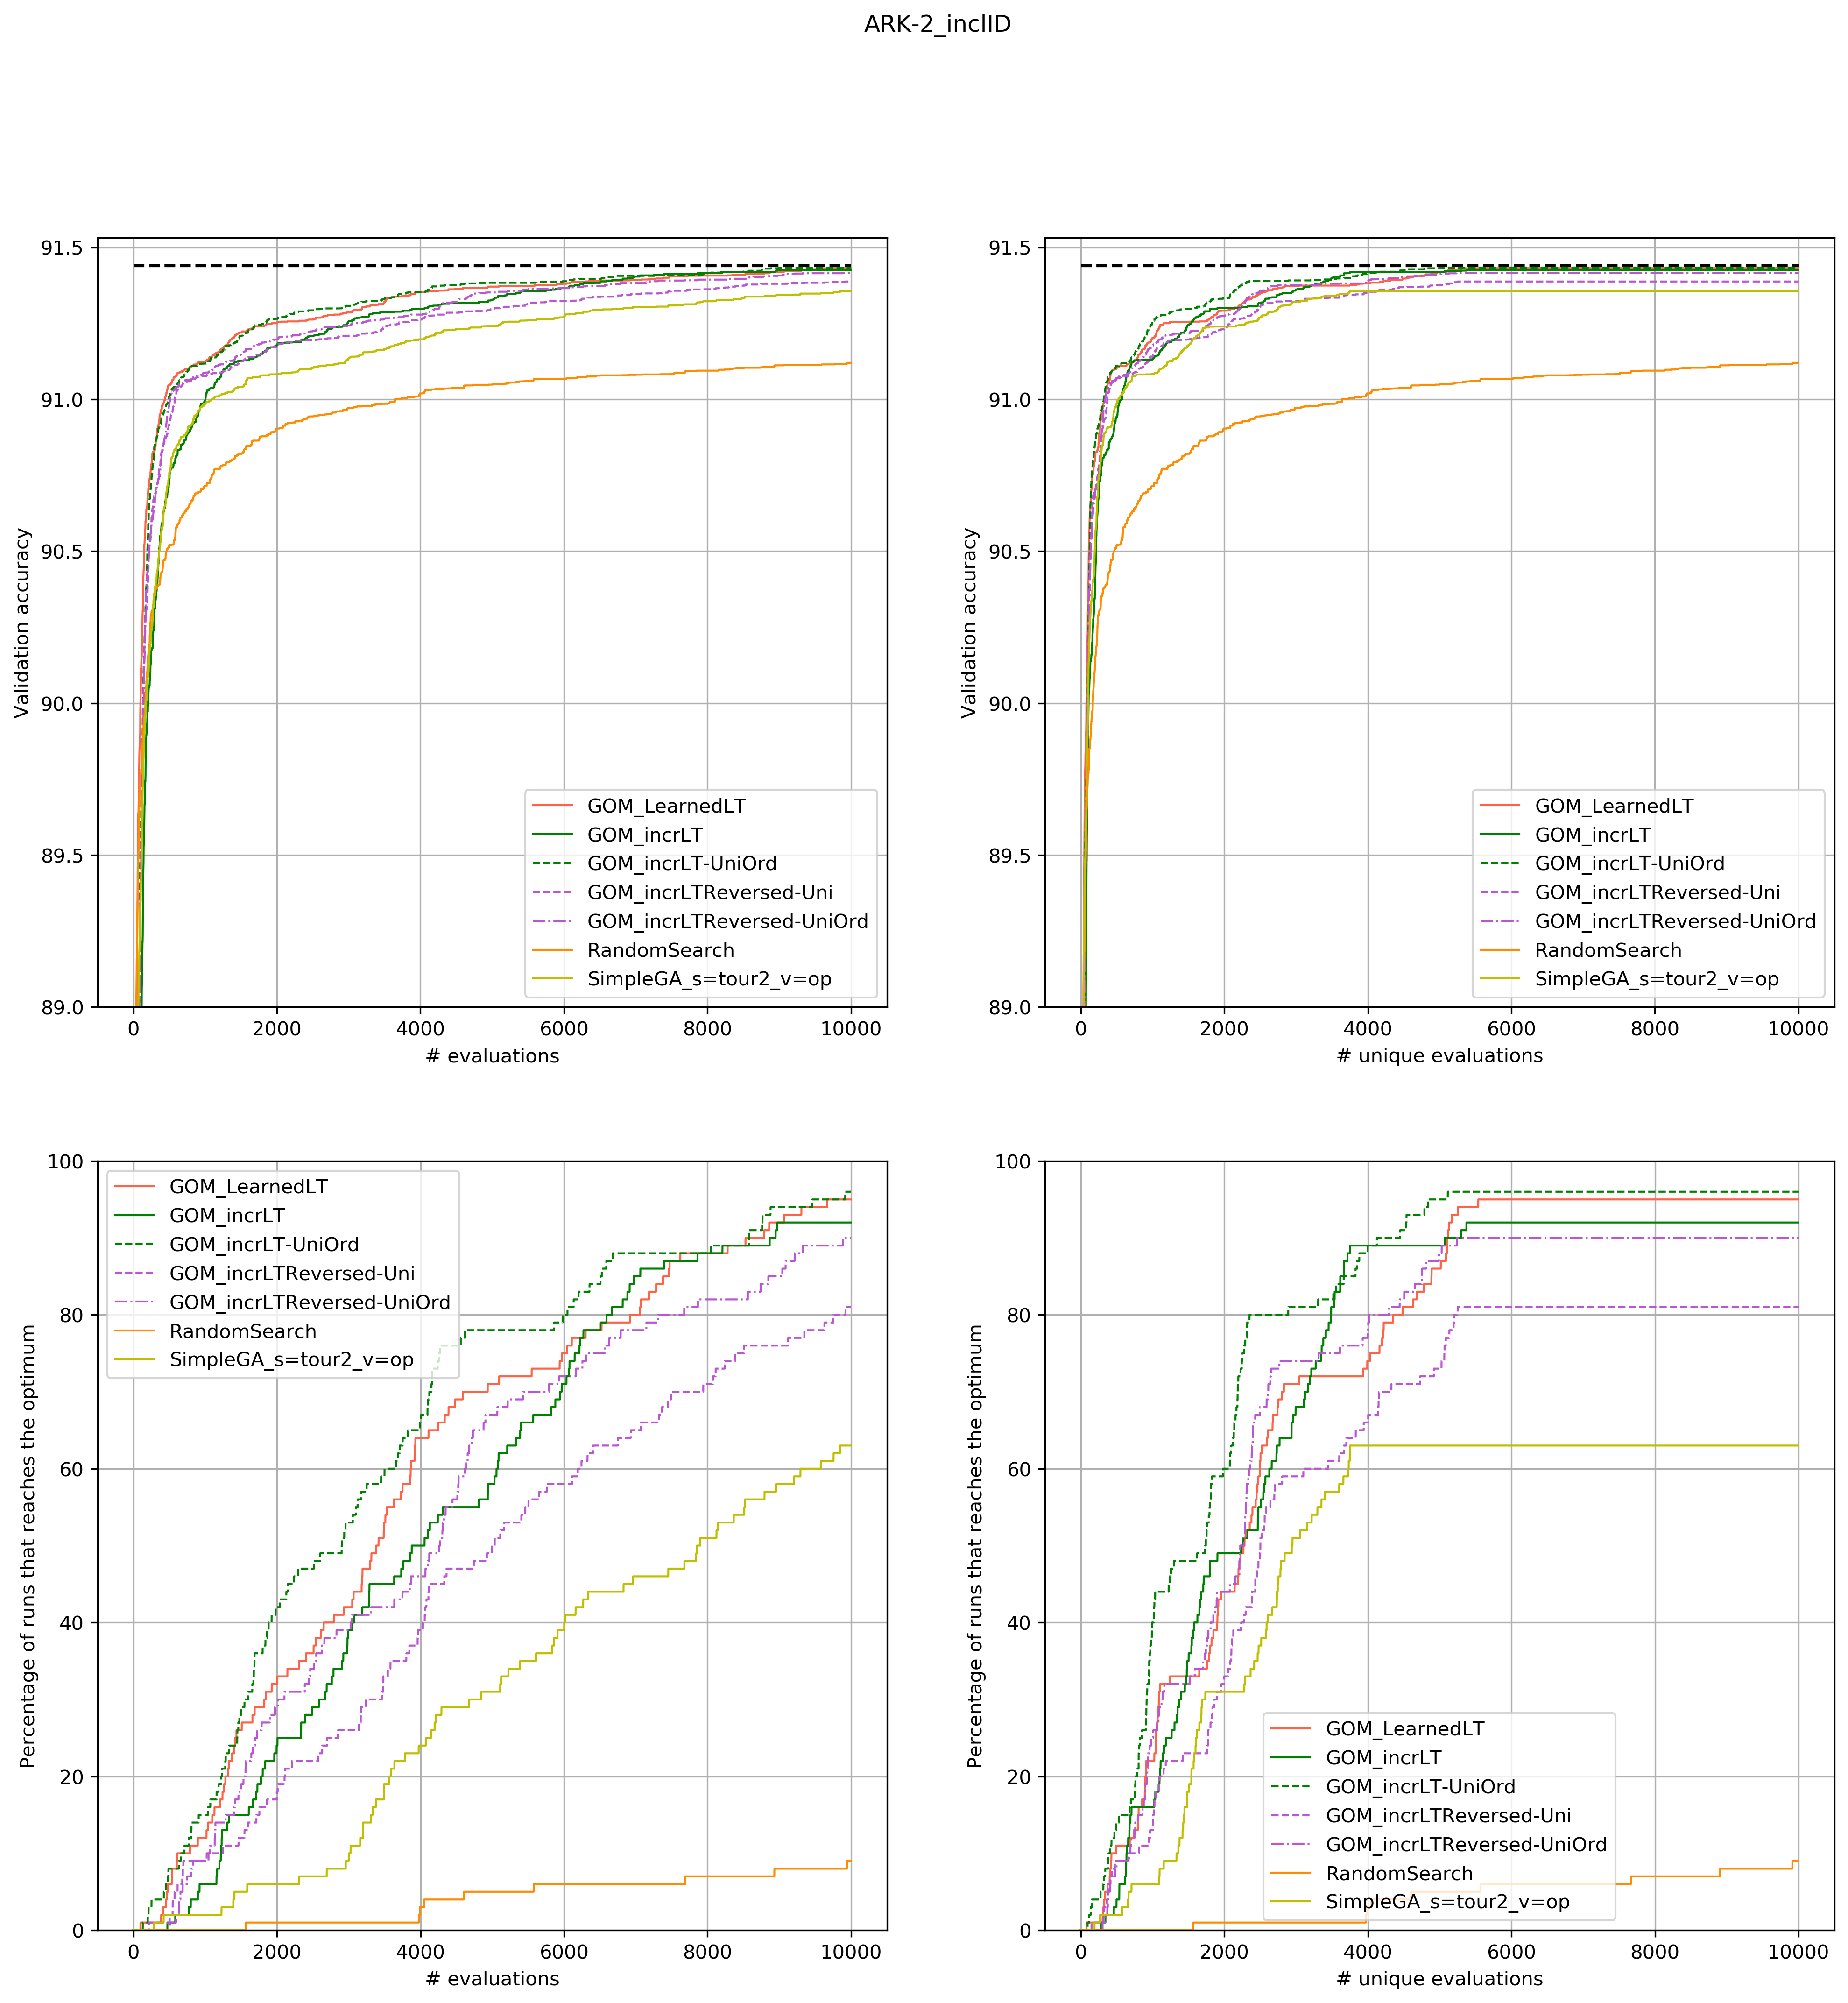

In [27]:
# Until 10000 absolute evaluations. Unique evaluations are also stored.

# Alphabet={0,1,2}. (so identity is included)
filename = "../data/exp8/data_convergence_012.json"

# Alphabet={0,1}. (so identity is excluded)
# filename = "../data/exp8/data_convergence_01.json"

important = ["GOM_incrLT-UniOrd", "GOM_incrLTReversed-UniOrd", "GOM_LearnedLT", 
             "GOM_incrLT", "SimpleGA_s=tour2_v=op", "GOM_incrLTReversed-Uni",
            "RandomSearch"]

for importantOnly in [False, True]:
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
    firstplots = [ax1, ax2]
    secondplots = [ax3, ax4]
    cm = plt.cm.Set1.colors
#     cycle = (cycler(color=cm) * cycler(linestyle=['-', '--']))
#     for ax in [ax1,ax2,ax3,ax4]:
#         ax.set_prop_cycle(cycle)

    numEvaluations = 10000;
    optimum = 91.44

    with open(filename) as json_file:
        rawdata = json.load(json_file)
        repetitions = rawdata["repetitions"]
        print("averages of", repetitions, "repetitions")

        fig.suptitle(rawdata['fitnessFunction'])
        algorithms = rawdata['experiments']
        totalBest = 0;

        for k, evaluationstype in enumerate(["absolute", "unique"]):

            for algo in algorithms:
                if(importantOnly and algo not in important):
                    continue
                data = algorithms[algo]["13"]
                numEntries = len(data)

                accuracies = np.zeros((numEntries, numEvaluations))
                optfound = np.zeros((numEntries, numEvaluations))

                for i, rep in enumerate(data):

                    convergenceValues = data[rep]["convergence"][evaluationstype]
                    fillUntil = min(len(convergenceValues), numEvaluations)

                    accuracies[i, 0:fillUntil] = convergenceValues[0:fillUntil]
                    if(fillUntil < numEvaluations):
                        accuracies[i, fillUntil:numEvaluations] = accuracies[i, fillUntil-1]

                    for j, value in enumerate(accuracies[i,:]):
                        if (value >= optimum):
                            optfound[i][j] = 1

                avgAccuracies = np.mean(accuracies, 0)
                stdAccuracies = np.std(accuracies, 0)

                totalOptfound = np.sum(optfound, 0) / repetitions * 100
                totalBest = max(totalBest, max(avgAccuracies))

                firstplots[k].plot(range(numEvaluations), avgAccuracies, label=algo, color=colorDict[algo][0], linestyle=colorDict[algo][1], linewidth=1)
#                 firstplots[k].fill_between(range(numEvaluations), avgAccuracies-stdAccuracies, avgAccuracies+stdAccuracies, alpha=0.1)

                secondplots[k].plot(range(numEvaluations), totalOptfound, label=algo, color=colorDict[algo][0], linestyle=colorDict[algo][1], linewidth=1)

            ax = firstplots[k]
            ax.set_ylim(89, optimum * 1.001)
            ax.legend()
            ax.set_xlabel('# evaluations')
            ax.set_ylabel('Validation accuracy')
            ax.hlines(optimum, 0, numEvaluations, linestyles='dashed')
        #     ax.set_xscale('log')
        #     ax.set_yscale('log')
            ax.grid()

            ax = secondplots[k]
            ax.set_ylim(0,100)
            ax.legend()
            ax.set_xlabel('# evaluations')
            ax.set_ylabel('Percentage of runs that reaches the optimum')
            ax.grid()

    ax2.set_xlabel("# unique evaluations")
    ax4.set_xlabel("# unique evaluations")


# Experiment 8.2: All algorithms on ARK-2 (Scalability Plots)

averages of 100 repetitions


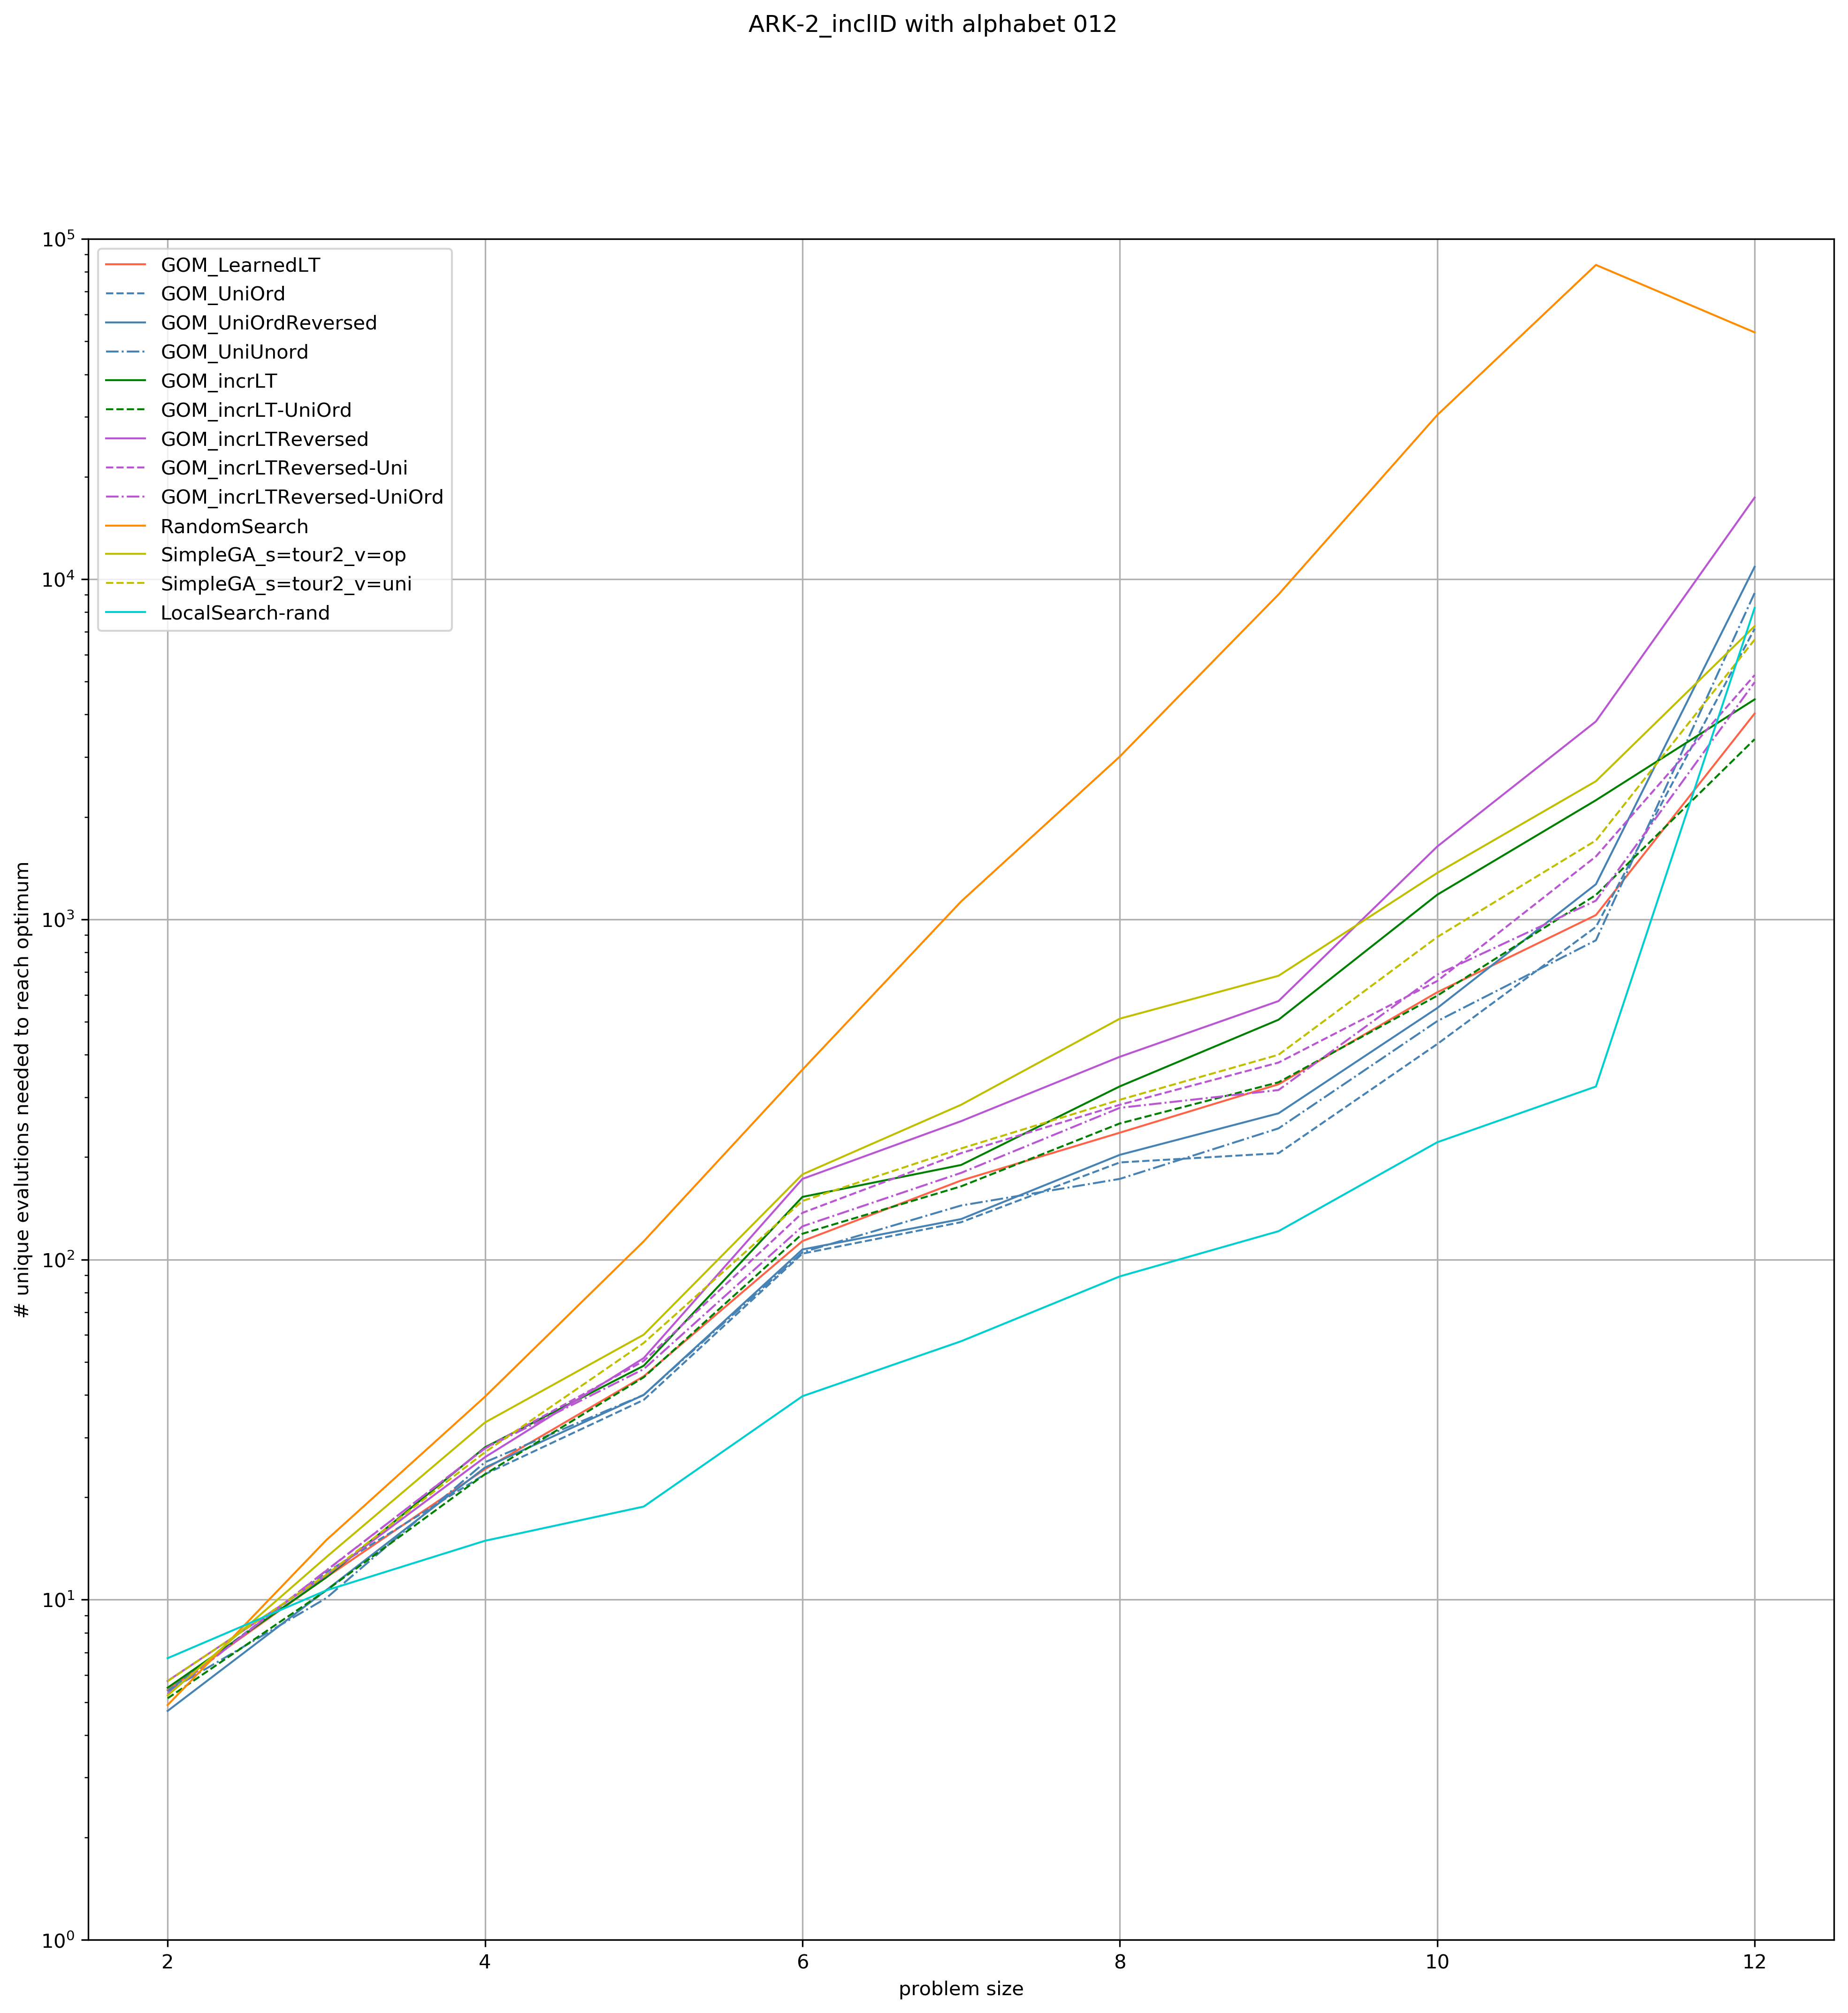

In [305]:
alphabet1 = "012"
alphabet2 = "012"

begin = 2;
end = 12;

for alphabet in [alphabet1]: #, alphabet2]:
    fig, (ax1) = plt.subplots(1, 1)
    cm = plt.cm.Set1.colors
    cycle = (cycler(color=cm) * cycler(linestyle=['-', '--']))
    ax1.set_prop_cycle(cycle)
    ax2.set_prop_cycle(cycle)

    selection = ["GOM_LearnedLT", "GOM_UniOrd", "GOM_UniUnord", "GOM_UniOrdReversed"]

    filename = "../data/exp8/data_scaling_" + alphabet + "/data_scaling__combined.json"
    
    with open(filename) as json_file:
        rawdata = json.load(json_file)
#         print(rawdata)

        fig.suptitle(rawdata['fitnessFunction'] + " with alphabet " + alphabet)
        algorithms = rawdata['experiments']

        repetitions = rawdata['repetitions']

        numAlgos = len(algorithms)

    #     for algo in selection:
        for algo in algorithms:

            data = algorithms[algo]
            numEntries = len(data)
            numEntries = min(numEntries, end - begin + 1)

            Evaluations = np.zeros((numEntries, repetitions))
            Times = np.zeros((numEntries, repetitions))

            for i, problemsize in enumerate(data):
                
                if i == end - begin + 1:
                    break;

                for j, rep in enumerate(data[problemsize]):

                    Evaluations[i][j] = data[problemsize][rep]["uniqueEvaluations"]
                    Times[i][j] = data[problemsize][rep]["timeTaken"]

            avgEvaluations = np.mean(Evaluations, 1);
            stdEvaluations = np.std(Evaluations, 1);
            avgTimes = np.mean(Times, 1);
            stdTimes = np.std(Times, 1)

            xrange = range(begin,begin + numEntries)

            ax1.plot(xrange, avgEvaluations, label=algo, color=colorDict[algo][0], linestyle=colorDict[algo][1], linewidth=1)
#             ax1.fill_between(xrange, avgEvaluations-stdEvaluations, avgEvaluations+stdEvaluations, alpha=0.1)
#             ax1.errorbar(xrange, avgEvaluations, yerr=stdEvaluations)

    #         ax2.plot(xrange, avgTimes, label=algo)
    #         ax2.fill_between(xrange, avgTimes-stdTimes, avgTimes+stdTimes, alpha=0.1)

        ax1.set_ylim(1,100000)
        ax1.legend()
        ax1.set_xlabel('problem size')
        ax1.set_ylabel('# unique evalutions needed to reach optimum')
        ax1.grid()
        ax1.set_yscale('log')
        
    
        print("averages of", repetitions, "repetitions")

### Sanity check for dip in scalability graph on ARK-2
Actually, we found out the cause of the dip. Regarding 12-layered NN's, there is 1 solution among the 5M solutions that has the optimum value of 91.44. Regarding 13-layered NN's, there are 14 solutions out of 1.5M that have the optimum of 91.44. This increase in optimal solutions makes the problem slightly easier to solve.

In [85]:
for x in ["12", "13"]:
    print("Displaying info for genotype length " + x)
    with open("../data/exp8/data_scaling_012/data_scaling_" + x + ".json") as json_file:
        data = json.load(json_file)
        total = 0
        data = data["experiments"]
        for algo in data:
            for item in data[algo][x]:
                total = total + data[algo][x][item]["uniqueEvaluations"]
            print(algo, total / 100)
        print()

Displaying info for genotype length 12
GOM_LearnedLT 4027.61
GOM_UniOrd 11176.13
GOM_UniUnord 20283.14
GOM_incrLT 24714.22
GOM_incrLT-UniOrd 28023.64
GOM_incrLTReversed-Uni 33245.62
GOM_incrLTReversed-UniOrd 38222.69

Displaying info for genotype length 13
GOM_LearnedLT 2848.1
GOM_UniOrd 7127.29
GOM_UniUnord 11798.45
GOM_incrLT 14370.35
GOM_incrLT-UniOrd 16681.8
GOM_incrLTReversed-Uni 19648.67
GOM_incrLTReversed-UniOrd 22320.37



## Significance tests for the scalability plot of ARK-2

In [318]:
def createDictionary(problemsize):
    dictionary = {};
    with open("../data/exp8/data_scaling_012/data_scaling__combined.json") as json_file:
        data = json.load(json_file)
        data = data["experiments"]
        for algo in data:
            values = []
            for i, item in enumerate(data[algo][problemsize]):
                values.append(data[algo][problemsize][item]["uniqueEvaluations"])
            dictionary[algo] = values

    # print(dictionary)
    return dictionary

dictionary = createDictionary("12")

In [310]:
for entry1 in dictionary:
    for entry2 in dictionary:
        if(entry1 == entry2):
            continue
        stat, p = mannwhitneyu(dictionary[entry1], dictionary[entry2], alternative='less')
        alpha = 0.05
        if p <= alpha and ("incrLT-UniOrd" in entry1):
            print("x =", entry1, "y =", entry2)
            print('Statistics=%.3f, p=%.3f' % (stat, p))
            print('Different distribution (reject H0)')
            print()
#         else:
#             print('Same distribution (fail to reject H0)')

x = GOM_incrLT-UniOrd y = GOM_LearnedLT
Statistics=3814.500, p=0.002
Different distribution (reject H0)

x = GOM_incrLT-UniOrd y = GOM_UniOrd
Statistics=2229.500, p=0.000
Different distribution (reject H0)

x = GOM_incrLT-UniOrd y = GOM_UniUnord
Statistics=2016.000, p=0.000
Different distribution (reject H0)

x = GOM_incrLT-UniOrd y = GOM_incrLT
Statistics=4197.000, p=0.025
Different distribution (reject H0)

x = GOM_incrLT-UniOrd y = GOM_incrLTReversed-Uni
Statistics=3252.500, p=0.000
Different distribution (reject H0)

x = GOM_incrLT-UniOrd y = GOM_incrLTReversed-UniOrd
Statistics=3645.500, p=0.000
Different distribution (reject H0)

x = GOM_incrLT-UniOrd y = SimpleGA_s=tour2_v=uni
Statistics=2997.000, p=0.000
Different distribution (reject H0)

x = GOM_incrLT-UniOrd y = GOM_incrLTReversed
Statistics=1517.000, p=0.000
Different distribution (reject H0)

x = GOM_incrLT-UniOrd y = SimpleGA_s=tour2_v=op
Statistics=2401.000, p=0.000
Different distribution (reject H0)

x = GOM_incrLT-UniO

In [319]:
def generateLatexTable(dictionary, withCorrection):
    count_gom_algorithms = 0
    count_other_algorithms = 0
    for entry in dictionary:
        if "GOM" in entry:
            count_gom_algorithms += 1
        else:
            count_other_algorithms += 1

    total_algorithms = count_gom_algorithms + count_other_algorithms
    amount_of_comparisons = ((total_algorithms)**2 - total_algorithms) / 2
    table = "\\begin{tabular}{|c|l|"
    end_of_line_full = "\\\\\\hline\n"
    end_of_line_partly = "\\\\\\cline{2-" + str(2 + len(dictionary)) + "}\n"
    for i in range(len(dictionary) + 2):
        table += "c|"
    table += ("}\n\\hline\n & & \\multicolumn{" + str(count_gom_algorithms))
    table += ("}{c|}{GOM} & \\multicolumn{" + str(count_other_algorithms) + "}{c|}{other}")
    table += end_of_line_full
    table += " &"
    for entry in sorted(dictionary):
        entry_string = entry.replace("GOM_", "")
        entry_string = entry_string.replace("_s=tour2_v=", "-")
        table += (" & \\rotatebox{90}{" + entry_string + "}")

    table += end_of_line_full
    table += "\\multirow{" + str(count_gom_algorithms) + "}{*}{GOM} "

    alpha = 0.05
    
    for i, entry1 in enumerate(sorted(dictionary)):
        if(i == count_gom_algorithms):
            table += "\\multirow{" + str(count_other_algorithms) + "}{*}{other} "
        entry_string = entry1.replace("GOM_", "")
        entry_string = entry_string.replace("_s=tour2_v=", "-")
        table += "& "
        table += entry_string
        for entry2 in sorted(dictionary):
            if(entry1 == entry2):
                table += "& -"
            else:
                stat, p = mannwhitneyu(dictionary[entry1], dictionary[entry2], alternative='less')
                if(withCorrection):
                    p = min(p * amount_of_comparisons, 1.0)
                value = '%.3f' % p
                if p <= alpha:
                    table += "& \\textbf{\\textcolor{red}{"
                    table += value
                    table += "}}"
                else:
                    table += ("& " + value)
    #             print("x =", entry1, "y =", entry2)
    #             print('Statistics=%.3f, p=%.3f' % (stat, p))
    #             print('Different distribution (reject H0)')
    #             print()
    #         else:
    #             print('Same distribution (fail to reject H0)')
        table += " "
        if i == count_gom_algorithms - 1 or i == count_gom_algorithms + count_other_algorithms - 1:
            table += end_of_line_full
        else:
            table += end_of_line_partly

    table += "\\end{tabular}"
    print(table)

In [321]:
generateLatexTable(createDictionary("12"), True)

\begin{tabular}{|c|l|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|}
\hline
 & & \multicolumn{9}{c|}{GOM} & \multicolumn{4}{c|}{other}\\\hline
 & & \rotatebox{90}{LearnedLT} & \rotatebox{90}{UniOrd} & \rotatebox{90}{UniOrdReversed} & \rotatebox{90}{UniUnord} & \rotatebox{90}{incrLT} & \rotatebox{90}{incrLT-UniOrd} & \rotatebox{90}{incrLTReversed} & \rotatebox{90}{incrLTReversed-Uni} & \rotatebox{90}{incrLTReversed-UniOrd} & \rotatebox{90}{LocalSearch-rand} & \rotatebox{90}{RandomSearch} & \rotatebox{90}{SimpleGA-op} & \rotatebox{90}{SimpleGA-uni}\\\hline
\multirow{9}{*}{GOM} & LearnedLT& -& \textbf{\textcolor{red}{0.000}}& \textbf{\textcolor{red}{0.000}}& \textbf{\textcolor{red}{0.000}}& 1.000& 1.000& \textbf{\textcolor{red}{0.000}}& 1.000& 1.000& \textbf{\textcolor{red}{0.000}}& \textbf{\textcolor{red}{0.000}}& \textbf{\textcolor{red}{0.000}}& \textbf{\textcolor{red}{0.046}} \\\cline{2-15}
& UniOrd& 1.000& -& \textbf{\textcolor{red}{0.000}}& 1.000& 1.000& 1.000& \textbf{\textcolor{red}{0.000}}& 1.000